#### Preamble

In [1]:
%matplotlib notebook

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.special import expit, logit

from keras import backend as K
from keras.layers import Activation, Dense
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy

from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

Using TensorFlow backend.


#### Notebook Environment 

In [3]:
plt.style.use('seaborn-notebook')
sns.set_context('notebook')
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [4]:
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.4.1'

In [5]:
sess = tf.InteractiveSession()

##### Constants

In [6]:
seed = 8888
rng = np.random.RandomState(seed)

In [7]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

# Simple 1D Gaussians Illustration

Consider the following 1D Gaussian distributions,

$$
\begin{align}
  p(x) &= \mathcal{N}(x \mid 1, 1^2), \\
  q(x) &= \mathcal{N}(x \mid 0, 2^2).
\end{align}
$$

In [8]:
mu_p = 1.
sigma_p = 1.

In [9]:
mu_q = 0.
sigma_q = 2.

In [10]:
p = tf.distributions.Normal(loc=mu_p, scale=sigma_p)
q = tf.distributions.Normal(loc=mu_q, scale=sigma_q)

In [11]:
xs = np.float32(np.linspace(-5., 5., 500))

<IPython.core.display.Javascript object>


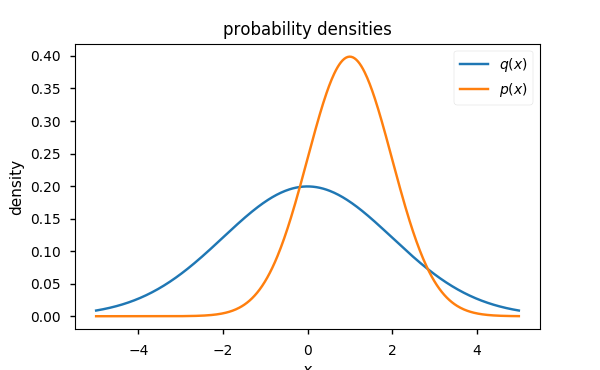

In [12]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('probability densities')

ax.plot(xs, q.prob(xs).eval(), label='$q(x)$')
ax.plot(xs, p.prob(xs).eval(), label='$p(x)$')

ax.set_xlim(-5.5, 5.5)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

plt.show()

## Density Ratio

The ratio of their probability densities is given by,

$$
r(x) = \frac{p(x)}{q(x)}.
$$

In [13]:
density_ratio = lambda x, p, q: tf.truediv(p.prob(x), q.prob(x))

In [14]:
density_ratios = density_ratio(xs, p, q).eval()

<IPython.core.display.Javascript object>


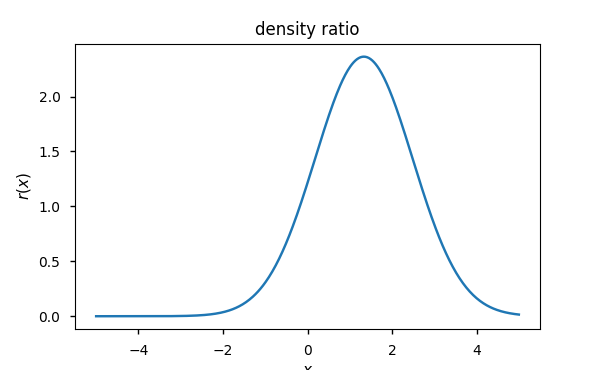

In [15]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('density ratio')

ax.plot(xs, density_ratios)

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

plt.show()

### Log density ratio of Gaussian distributions

The log of the density ratio between Gaussians can be simplied nicely as,

$$
\log \sigma_q - \log \sigma_p + \frac{1}{2} \left \{ \left ( \frac{x-\mu_p}{\sigma_p}^2 \right ) - 
                                                     \left ( \frac{x-\mu_q}{\sigma_q}^2 \right ) \right \}.
$$

In [16]:
def log_density_ratio_gaussians(x, mu_p, sigma_p, mu_q, sigma_q):

    r_p = (x - mu_p) / sigma_p
    r_q = (x - mu_q) / sigma_q

    return np.log(sigma_q) - np.log(sigma_p) + .5 * (r_q**2 - r_p**2)

In [17]:
log_density_ratios = log_density_ratio_gaussians(
    xs, mu_p, sigma_p, mu_q, sigma_q
)

We can verify this is correct,

In [18]:
assert np.allclose(log_density_ratios, np.log(density_ratios))

<IPython.core.display.Javascript object>


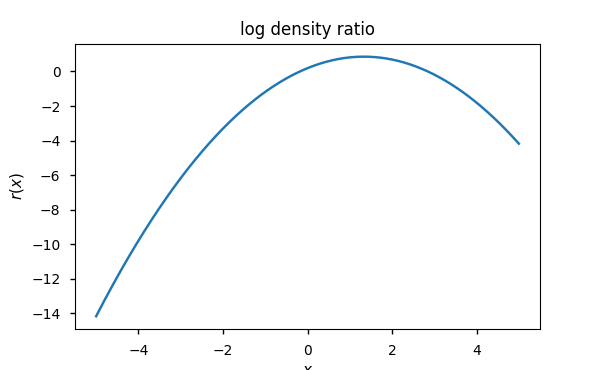

In [19]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('log density ratio')

ax.plot(xs, log_density_ratios)

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

plt.show()

## Density ratio estimation by probabilistic classification

Suppose now that we don't have access to the densities $p(x)$ and $q(x)$ for whatever reason, which is quite a common scenario. Density ratio estimation is concerned with directly estimating $r(x)$ using only samples from these distributions. Preferably, we can do this without resorting to estimating the individual densities $p(x)$ or $q(x)$, since the error in estimating the denominator $q(x)$ is magnified dramatically. One of the most simple approaches is probabilistic classification.

---

Let $\mathcal{D}_p = \{x_p^{(i)}\}_{i=1}^{n_p}$ and $\mathcal{D}_q = \{x_q^{(j)}\}_{j=1}^{n_q}$ be sets of samples drawn from distributions $p(x)$ and $q(x)$, respectively.

In [20]:
n_p = n_q = 500

In [21]:
samples_p = p.sample(sample_shape=(n_p,)).eval()
samples_q = q.sample(sample_shape=(n_q,)).eval()

We assign labels $y=1$ to samples from $\mathcal{D}_p$ and $y=0$ to samples from $\mathcal{D}_q$. Now the two densities can be rewritten as:

$$
\begin{align}
p(x) & = p(x \mid y = 1), \\
q(x) & = p(x \mid y = 0). \\
\end{align}
$$

(Need to revise notation here... We're overloading $p$)

---

Let $n = n_p + n_q$, we form the dataset $\{ (x_k, y_k) \}_{k=1}^n$, where

$$
\begin{align}
  (x_1, \dotsc, x_n) &= (x_p^{(1)}, \dotsc, x_p^{(n_p)}, 
                         x_q^{(1)}, \dotsc, x_q^{(n_q)}), \\
  (y_1, \dotsc, y_n) &= (\underbrace{1, \dotsc, 1}_{n_p},
                         \underbrace{0, \dotsc, 0}_{n_q}).
\end{align}
$$

In [22]:
x = np.hstack([samples_p, samples_q])
y = np.hstack([np.ones_like(samples_p), 
               np.zeros_like(samples_q)])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.2, random_state=rng
)

<IPython.core.display.Javascript object>


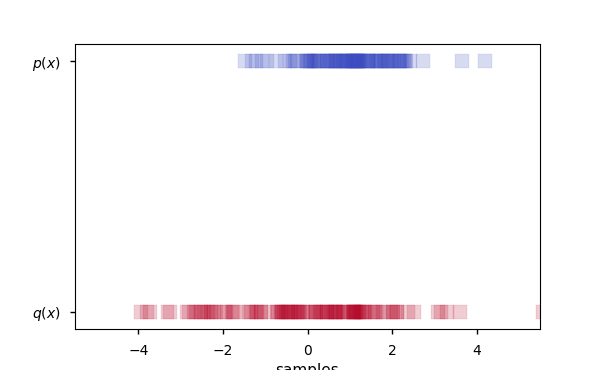

In [24]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

ax.set_xlim(-5.5, 5.5)

ax.set_xlabel('samples')
ax.set_yticks([0, 1])
ax.set_yticklabels(['$q(x)$', '$p(x)$'])

plt.show()

Now, by Bayes's rule,

$$
p(x \mid y) = \frac{p(y \mid x) p(x)}{p(y)}.
$$

Hence, we can write the density ratio $r(x)$ in terms of class probabilities,

$$
\begin{align}
  r(x) & = \frac{p(x)}{q(x)} \\
       & = \frac{p(x \mid y = 1)}{p(x \mid y = 0)} \\
       & = \left ( \frac{p(y = 1 \mid x) p(x)}{p(y = 1)} \right ) 
           \left ( \frac{p(y = 0 \mid x) p(x)}{p(y = 0)} \right ) ^ {-1} \\
       & = \frac{p(y = 0)}{p(y = 1)} 
           \frac{p(y = 1 \mid x)}{p(y = 0 \mid x)}
\end{align}
$$

We can approximate the ratio of prior densities by the ratio of sample sizes:

$$
\frac{p(y = 0)}{p(y = 1)} \approx \frac{n_q}{n_p + n_q} 
                                  \frac{n_p + n_q}{n_p} 
                          = \frac{n_q}{n_p}
$$

The class-posterior probability $p(y \mid x)$ is estimated by training a probabilitic classifier to discriminate between samples from $\mathcal{D}_p$ and $\mathcal{D}_q$. Then, an estimator of the density ratio $\hat{r}(x)$ can be constructed from an estimator of the class-posterior probability $\hat{p}(y \mid x)$,

$$
\hat{r}(x) = \frac{n_q}{n_p} 
             \frac{\hat{p}(y = 1 \mid x)}
                  {\hat{p}(y = 0 \mid x)}
           = \frac{n_q}{n_p} 
             \frac{\hat{p}(y = 1 \mid x)}
                  {1 - \hat{p}(y = 1 \mid x)}.
$$

To reduce clutter, let us assume for now that $n_p = n_q$ and denote the probabilistic classifier $D_{\theta}(x) := \hat{p}(y = 1 \mid x)$. Then we can write $\hat{r}(x)$ as 

$$
\begin{align}
\hat{r}(x)   = \frac{D(x)}{1 - D(x)}
           & = \exp \left ( \log \frac{D(x)}{1 - D(x)} \right ) \\
           & = \exp \left ( \sigma^{-1}(D(x)) \right ). \\
\end{align}                               
$$

### Bayes optimal classifier

Conversely, the Bayes optimal classifier can be written as a function of the density ratio,

$$
p(y=1 \mid x) = \sigma(\log r(x)) = \frac{p(x)}{p(x) + q(x)}.
$$

In [25]:
classifier_optimal = lambda x, p, q: tf.truediv(p.prob(x), 
                                                p.prob(x) + q.prob(x))

In [26]:
y_pred_optimal = classifier_optimal(x_test, p, q).eval()

<IPython.core.display.Javascript object>


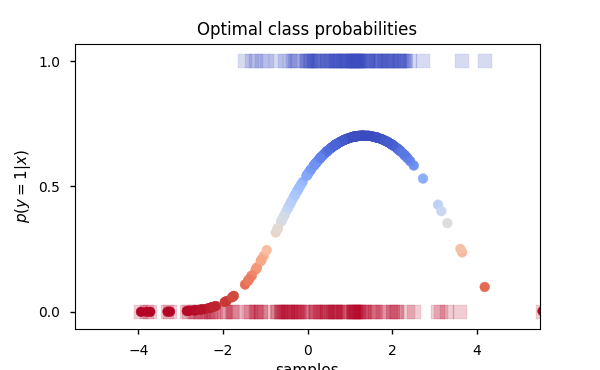

In [27]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('Optimal class probabilities')

ax.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

ax.scatter(x_test, y_pred_optimal, c=y_pred_optimal, cmap='coolwarm_r')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('samples')

ax.set_yticks([0., .5, 1.])
ax.set_ylabel('$p(y=1|x)$')

plt.show()

### Logistic regression

Perhaps the most conceptually straightforward approach for probabilistic classification is *logistic regression*. 

---

We define a fully-connected neural network with two hidden layers and softplus activations.

In [28]:
classifier = Sequential([
    Dense(10, input_dim=1, activation='softplus'),
    Dense(20, activation='softplus'),
    Dense(1, name='log_odds'),
    Activation('sigmoid')
])

In [29]:
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy')

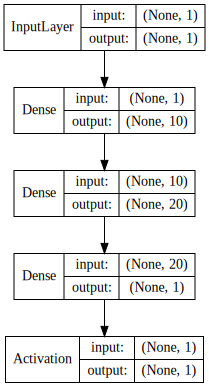

In [30]:
SVG(model_to_dot(classifier, show_layer_names=False, show_shapes=True)
    .create(prog='dot', format='svg'))

In [31]:
hist = classifier.fit(x_train, y_train,
                      shuffle=True,
                      batch_size=100,
                      epochs=250,
                      validation_data=(x_test, y_test),
                      verbose=0)

<IPython.core.display.Javascript object>


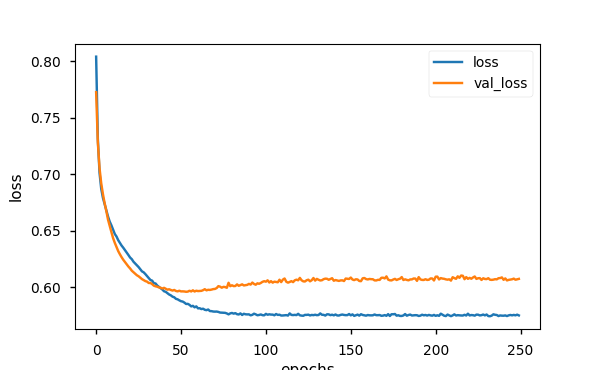

In [32]:
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('loss')
ax.set_xlabel('epochs')

plt.show()

In [33]:
y_pred = classifier.predict(x_test).ravel()

<IPython.core.display.Javascript object>


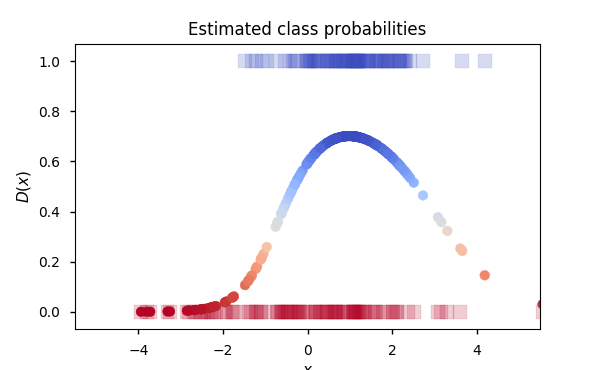

In [34]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('Estimated class probabilities')

ax.scatter(x_test, y_test, c=y_test, s=10.**2,
           marker='s', alpha=.2, cmap='coolwarm_r')

ax.scatter(x_test, y_pred, c=y_pred, cmap='coolwarm_r')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$D(x)$')

plt.show()

In [35]:
ys_optimal = classifier_optimal(xs, p, q).eval()
ys = classifier.predict(xs).ravel()

<IPython.core.display.Javascript object>


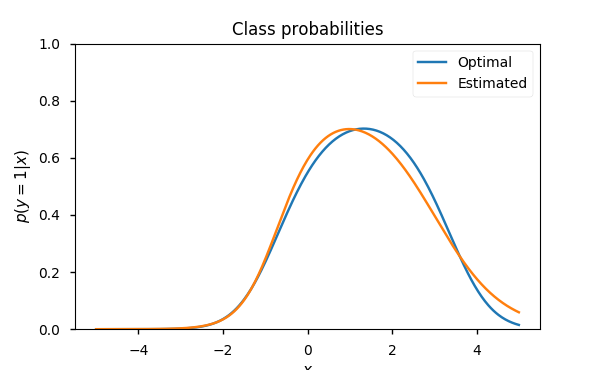

In [36]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('Class probabilities')

ax.plot(xs, ys_optimal, label='Optimal')
ax.plot(xs, ys, label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylim(0., 1.)
ax.set_ylabel('$p(y=1|x)$')

ax.legend()

plt.show()

### Density ratio estimator

In [37]:
log_ratio_estimator = Model(
    classifier.input,
    classifier.get_layer('log_odds').output
)

In [38]:
log_odds = log_ratio_estimator.predict(xs).ravel()
log_density_ratios = log_density_ratio_gaussians(
    xs, mu_p, sigma_p, mu_q, sigma_q
)

In [39]:
assert np.allclose(ys, expit(log_odds))

In [40]:
# side note: the following is true analytically 
# but evaluates to false, even with some tolerance
np.allclose(xs, logit(expit(xs)))

False

In [41]:
# hence this assert will actually fail but not
# for the reasons we actually care about
# assert np.allclose(logit(ys), log_odds)

<IPython.core.display.Javascript object>


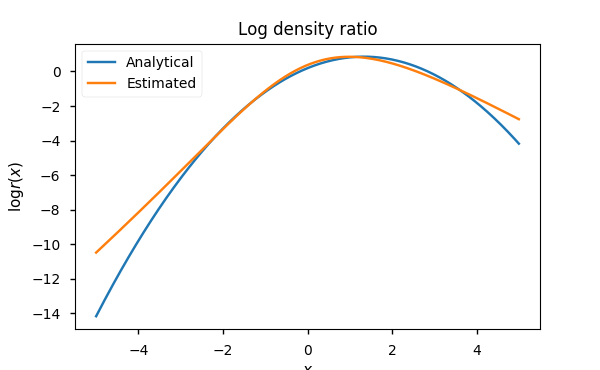

In [42]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('Log density ratio')

ax.plot(xs, log_density_ratios, label='Analytical')
ax.plot(xs, log_odds, label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$\log r(x)$')

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


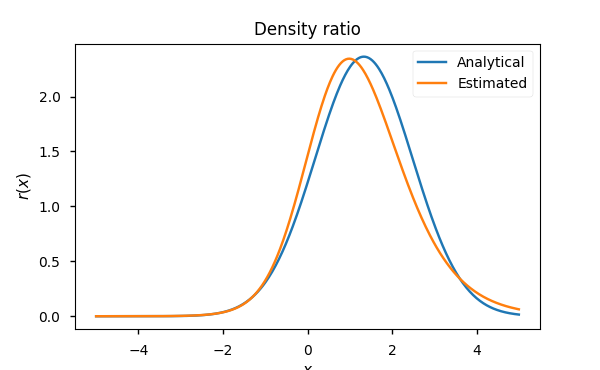

In [43]:
fig, ax = plt.subplots(figsize=golden_size(6))

ax.set_title('Density ratio')

ax.plot(xs, density_ratio(xs, p, q).eval(), label='Analytical')
ax.plot(xs, np.exp(log_odds), label='Estimated')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

ax.legend()

plt.show()

## KL divergence estimation

A natural application of density ratio estimation is divergence estimation. Namely, approximating a divergence from the general family of $f$-divergences using only samples. Here, we will approximate the Kullback-Liebler (KL) divergence between $P$ and $Q$ without using their respective densities, $p(x)$ and $q(x)$.

### Analytical

In [44]:
tf.distributions.kl_divergence(p, q).eval()

0.44314718

#### KL divergence between Gaussians

For Gaussian distributions, the KL divergence can be evaluated analytically as,

$$
\log \sigma_q - \log \sigma_p - \frac{1}{2} 
    \left \{ 1 - \left (\frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{\sigma_q^2} \right ) \right \}.
$$

In [45]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
    
    r = mu_p - mu_q
   
    return (np.log(sigma_q) - np.log(sigma_p) 
            - .5 * (1. - (sigma_p**2 + r**2) / sigma_q**2))

In [46]:
kl_analytical = kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q)
kl_analytical

0.44314718055994529

### Monte Carlo estimation

In [47]:
mc_samples = 50

In [48]:
samples_p = p.sample(sample_shape=(mc_samples,)).eval()

In [49]:
# MC samples with analytical log density ratio
kl_mc = pd.Series(
    log_density_ratio_gaussians(samples_p, mu_p, sigma_p, mu_q, sigma_q)
)

In [50]:
# MC samples with density ratio estimator
kl_mc_dre = pd.Series(log_ratio_estimator.predict(samples_p).ravel())

<IPython.core.display.Javascript object>


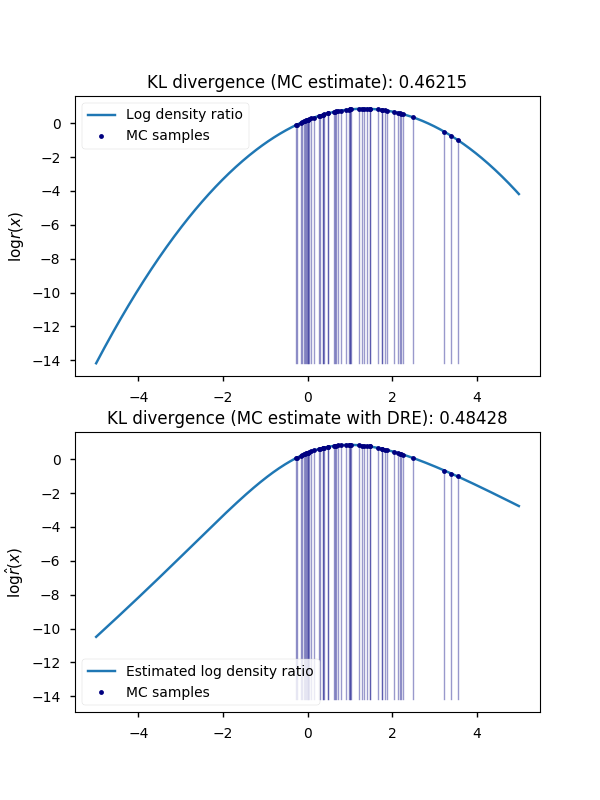

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 8))

log_density_ratio_min = np.repeat(np.min(log_density_ratios), 
                                  mc_samples)

ax1.set_title('KL divergence (MC estimate): {:.5f}'
             .format(np.mean(kl_mc)))

ax1.plot(xs, log_density_ratios, label='Log density ratio')

ax1.plot(samples_p, kl_mc, '.', color='navy', label='MC samples')

ax1.plot([samples_p, samples_p],
         [log_density_ratio_min, kl_mc], 
         linewidth=1., alpha=.4, color='navy')

ax1.set_ylabel('$\log r(x)$')

ax1.legend()

ax2.set_title('KL divergence (MC estimate with DRE): {:.5f}'
             .format(np.mean(kl_mc_dre)))

ax2.plot(xs, log_odds, label='Estimated log density ratio')

ax2.plot(samples_p, kl_mc_dre, '.', color='navy', label='MC samples')

ax2.plot([samples_p, samples_p],
         [log_density_ratio_min, kl_mc_dre], 
         linewidth=1., alpha=.4, color='navy')

ax2.set_ylabel('$\log \hat{r}(x)$')

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax2.legend()

plt.show()

#### Increasing MC sample size

In [52]:
mc_samples = 5000

In [53]:
samples_p = p.sample(sample_shape=(mc_samples,)).eval()

In [54]:
# MC samples with analytical log density ratio
kl_mc = pd.Series(
    log_density_ratio_gaussians(samples_p, mu_p, sigma_p, mu_q, sigma_q)
)

In [55]:
# MC samples with density ratio estimator
kl_mc_dre = pd.Series(log_ratio_estimator.predict(samples_p).ravel())

In [56]:
kl_estimates = pd.concat([kl_mc, kl_mc_dre], axis=1, 
                         keys=['kl_mc', 'kl_mc_dre'])
kl_estimates.describe()

,kl_mc,kl_mc_dre
count,5000.000000,5000.000000
mean,0.437779,0.437814
std,0.596221,0.580184
min,-5.995524,-5.625906
25%,0.301282,0.291181
50%,0.669817,0.655026
75%,0.816464,0.807633
max,0.859814,0.851987


<IPython.core.display.Javascript object>


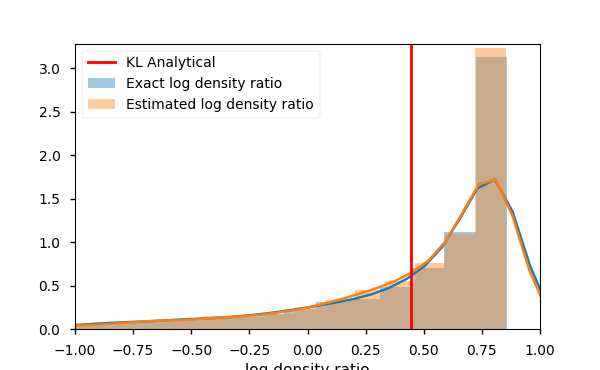

In [57]:
fig, ax = plt.subplots(figsize=golden_size(6))

sns.distplot(kl_estimates.kl_mc, ax=ax, label='Exact log density ratio')
sns.distplot(kl_estimates.kl_mc_dre, ax=ax,  
             label='Estimated log density ratio')

ax.axvline(x=kl_analytical, color='r', linewidth=2., 
           label='KL Analytical')

ax.set_xlim(-1, 1)
ax.set_xlabel('log density ratio')

ax.legend()

plt.show()

<IPython.core.display.Javascript object>


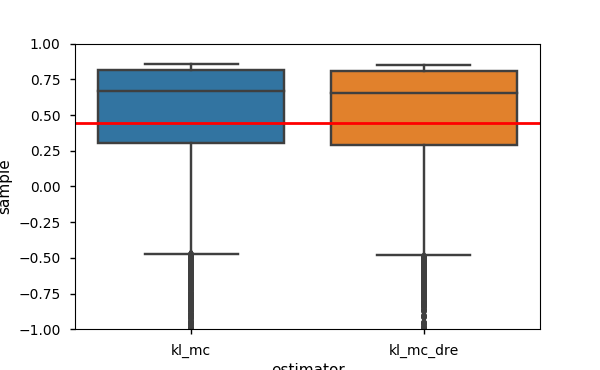

In [58]:
fig, ax = plt.subplots(figsize=golden_size(6))

sns.boxplot(x='estimator', y='sample',
            data=pd.melt(kl_estimates, 
                         var_name='estimator', 
                         value_name='sample'), ax=ax)

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_ylim(-1, 1)

plt.show()

In [59]:
# Cumulative mean of MC samples
kl_estimates_cum_mean = kl_estimates.expanding().mean()

<IPython.core.display.Javascript object>


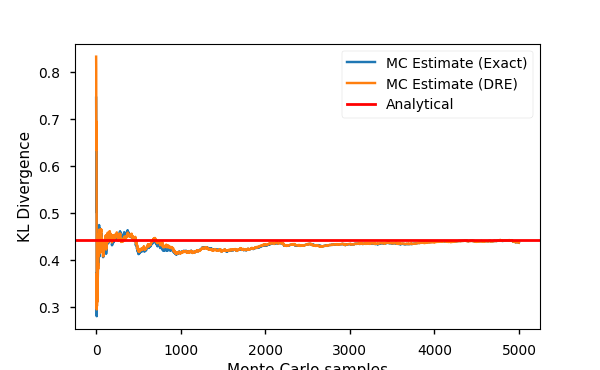

In [60]:
fig, ax = plt.subplots(figsize=golden_size(6))

kl_estimates_cum_mean.plot(ax=ax, y='kl_mc', 
                           label='MC Estimate (Exact)')

kl_estimates_cum_mean.plot(ax=ax, y='kl_mc_dre', 
                           label='MC Estimate (DRE)', )

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')

ax.legend()

plt.show()

#### Intermezzo: Symmetric KL (Jensen-Shannon) divergence

The Jensen-Shannon divergence is given by

$$
\mathrm{JS}[p \| q]  = \frac{1}{2}( \mathrm{KL}[p \| m] + 
                                    \mathrm{KL}[q \| m] ),
$$

where $m$ is the mixture density

$$
m(x) = \frac{p(x) + q(x)}{2}.
$$

This cannot be evaluated analytically (in closed-form) since the KL divergence between a Gaussian and a mixture of Gaussians is not available in closed-form. Hence, we estimate JS divergence by estimating its constituent KL divergence terms with Monte Carlo sampling. 

In [61]:
mc_samples = 10000

In [62]:
x_p = p.sample(sample_shape=(mc_samples,)).eval()
x_q = q.sample(sample_shape=(mc_samples,)).eval()

In [63]:
mixture_prob = lambda x, p, q: .5 * (p.prob(x) + q.prob(x))

$$
  \log \frac{p_1(x)}{(p_1(x) + p_2(x)) / 2} 
= \log p_1(x) - \log \{ p_1(x) + p_2(x) \} - \log 2
$$

In [64]:
def log_density_ratio_mixture(x, p1, p2): 

    return p1.log_prob(x) - tf.log(mixture_prob(x, p1, p2))

In [65]:
def js_divergence_mc(x_p, x_q, p, q):
    
    return .5 * (log_density_ratio_mixture(x_p, p, q) + 
                 log_density_ratio_mixture(x_q, q, p))

In [66]:
js_mc = pd.Series(js_divergence_mc(x_p, x_q, p, q).eval())
js_mc.mean()

0.12771526

Interestingly, the JS divergence is related to the binary cross-entropy loss,

$$
\begin{align}
  \sup_{\theta} 
  \left \{ \mathbb{E}_{p(x)} [\log D_{\theta}(x)] +
           \mathbb{E}_{q(x)} [\log(1-D_{\theta}(x))] \right\}
  & \leq 2 \cdot \mathrm{JS}[p \|q ] - \log 4 \\
  & = 2 \left \{ \mathrm{JS}[p \|q ] - \log 2 \right \}.
\end{align}
$$

Negating both sides, we have

$$
\begin{align}
  {-} \inf_{\theta} \left \{ {-} \mathbb{E}_{p(x)} [\log D_{\theta}(x)] 
                             {-} \mathbb{E}_{q(x)} [\log(1-D_{\theta}(x))] \right\}
  & \geq 2 \left \{ \log 2 - \mathrm{JS}[p \|q ] \right \}.
\end{align}
$$

Finally, halving both sides, we obtain
$$
 {-} \inf_{\theta} 
    \left \{ - \frac{1}{2} \mathbb{E}_{p(x)} [\log D_{\theta}(x)] 
            {-} \frac{1}{2} \mathbb{E}_{q(x)} [\log(1-D_{\theta}(x))] 
    \right\}
  \geq \log 2 - \mathrm{JS}[p \|q ].
$$

In [67]:
np.log(2.) - js_mc.mean()

0.56543192076952475

Compare this with the last 10 values of the training and validation loss.

In [68]:
hist_df.tail(n=10)

,loss,val_loss
240,0.574613,0.606388
241,0.574872,0.607644
242,0.574297,0.605857
243,0.574933,0.606334
244,0.575266,0.606556
245,0.574930,0.606873
246,0.575319,0.607448
247,0.574940,0.606458
248,0.575553,0.606798
249,0.574863,0.607222


<IPython.core.display.Javascript object>


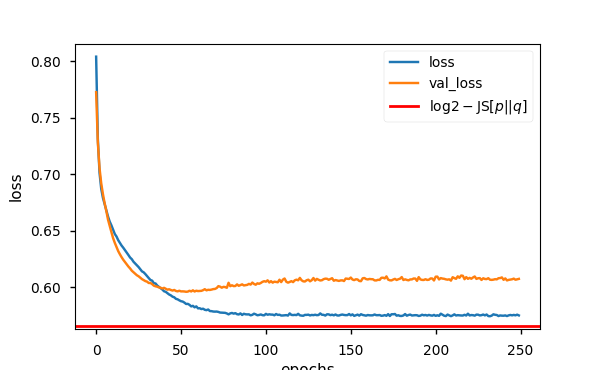

In [69]:
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.axhline(y=np.log(2.) - js_mc.mean(), 
           color='r', linewidth=2., 
           label='$\log 2 - \mathrm{JS}[p || q ]$')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')

ax.legend()

plt.show()

Coincidence? I think not. We're effectively minimizing the following loss,

$$
  { - \pi \mathbb{E}_{p(x)} [\log D_{\theta}(x)] }
  { - (1 - \pi) \mathbb{E}_{q(x)} [\log(1-D_{\theta}(x))] },
$$

where $\pi = \frac{n_p}{n_p + n_q} = \frac{1}{2}$. Since we set $n_p = n_q$, we sought the minima of loss function

$$
  { - \frac{1}{2} \mathbb{E}_{p(x)} [\log D_{\theta}(x)] }
  { - \frac{1}{2} \mathbb{E}_{q(x)} [\log(1-D_{\theta}(x))] }
$$

until convergence, which we showed is an upper bound on $\log 2 - \mathrm{JS}[p \|q ]$.

---

Just before, we took samples from $p(x)$ and $q(x)$ to estimate the JS divergence. Let's evaluate the loss on these samples,

In [70]:
x = np.hstack([x_p, x_q])
y = np.hstack([np.ones_like(x_p), 
               np.zeros_like(x_q)])

In [71]:
classifier.evaluate(x, y, batch_size=100)

20000/20000 [==============================] - 0s 15us/step


0.56833177953958514

Note this is just a convenience function for evaluating the following,

In [72]:
K.eval(K.mean(binary_crossentropy(K.constant(np.atleast_2d(y).T), 
                                  K.constant(classifier.predict(x)))))

0.56833196

This is close to, and slightly higher than $\log 2 - \mathrm{JS}[p \|q ]$ (reproduced below), as expected.

In [73]:
np.log(2.) - js_mc.mean()

0.56543192076952475

The technique of density ratio estimation by probabilistic classification is very powerful. As we explored in this notebook, it allows us to approximate $f$-divergences in situations where distributions $P(x)$ and $Q(x)$ are *implicit*. That is, their respective probability densities $p(x)$ and $q(x)$ are not available, either because they are analytically or computationally intractable.

## What's Next

Next, we will look at Generative Adversarial Networks (GANs)[^1] from a density ratio estimation perspective and illustrate how they simultaneously approximate the JS divergence between $P(x)$ and $Q(x)$ using a probabilistic classifier, and then minimize the approximation with respect to the parameters of a generative process that underlies $Q(x)$.

We will also look at density ratio estimation by divergence estimation, which is not unlike the approach of probabilistic classification, but uses different losses that bound the $f$-divergences in the same way that the binary cross-entropy loss bounds the JS divergence. We will later generalize these approaches to the unified framework of density ratio fitting under the Bregman divergence[^2].

## Further Reading

I will soon write a blog article and supplement it with the code and results from this notebook. Until then, I recommend the papers and book which inspired this,

- M. Sugiyama, T. Suzuki, and T. Kanamori, **Density Ratio Estimation in Machine Learning.** Cambridge University Press, 2012.
- M. Uehara, I. Sato, M. Suzuki, K. Nakayama, and Y. Matsuo, **"Generative Adversarial Nets from a Density Ratio Estimation Perspective,"** Oct. 2016.
- S. Mohamed and B. Lakshminarayanan, **"Learning in Implicit Generative Models,"** in The 5th International Conference on Learning Representations, 2017.

## References

[^1]: I. J. Goodfellow et al., "Generative Adversarial Networks," in Advances in Neural Information Processing Systems 27, 2014, pp. 2672–2680.

[^2]: M. Sugiyama, T. Suzuki, and T. Kanamori, "Density-ratio matching under the Bregman divergence: a unified framework of density-ratio estimation," Ann. Inst. Stat. Math., vol. 64, no. 5, pp. 1009–1044, Oct. 2012.